In [5]:
import numpy as np
import illustris_python as il
import matplotlib.pyplot as plt

In [6]:
basePath = '/orange/lblecha/IllustrisTNG/Runs/TNG50-1/output'

## Reading from the Group and Subhalo Catalog

In [56]:
fields = ['SubhaloMass','SubhaloSFRinRad']
subhalos = il.groupcat.loadSubhalos(basePath,1,fields=fields)
print(subhalos['count'])
print(subhalos['SubhaloMass'].shape)

689643
(689643,)


In [38]:
mass_msun = subhalos['SubhaloMass'] * 1e10 / 0.704

Text(0, 0.5, 'Star Formation Rate [$M_\\odot / yr$]')

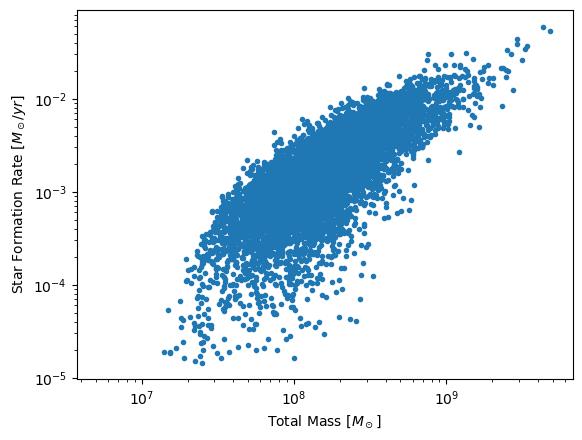

In [39]:
plt.plot(mass_msun,subhalos['SubhaloSFRinRad'],'.')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Mass [$M_\odot$]')
plt.ylabel('Star Formation Rate [$M_\odot / yr$]')

In [40]:
#loading the primary subhalo IDs

GroupFirstSub = il.groupcat.loadHalos(basePath,1,fields=['GroupFirstSub'])
GroupFirstSub.dtype

dtype('int32')

In [57]:
np.sum(GroupFirstSub>=0)

np.int64(667139)

In [67]:
## loading the  5 most massive central subhalos and printing their gas fraction

ptNumGas = il.snapshot.partTypeNum('gas') # 0
ptNumStars = il.snapshot.partTypeNum('stars') # 4

for i in range(5):
    all_fields = il.groupcat.loadSingle(basePath,1,subhaloID=GroupFirstSub[i])
    gas_mass   = all_fields['SubhaloMassInHalfRadType'][ptNumGas]
    stars_mass = all_fields['SubhaloMassInHalfRadType'][ptNumStars]
    frac = gas_mass / (gas_mass + stars_mass)
    print(GroupFirstSub[i], frac)

0 0.9688513
24 0.93712336
35 0.96288127
50 0.9623923
79 0.96458375


In [ ]:
il.snapshot.snapPath(basePath,99)

In [138]:

# Load subhalo catalog (e.g., for host halo index)
subhalos = il.groupcat.loadSubhalos(basePath, snapNum=1, fields=['SubhaloMass', 'SubhaloGrNr'])

# Get the "index-based IDs" for subhalos (0 to N-1)
subhalo_indices = np.arange(len(subhalos['SubhaloMass']))
print(f"Subhalo indices: {subhalo_indices}")

Subhalo indices: [     0      1      2 ... 689640 689641 689642]


In [102]:
subhalo_indices

array([     0,      1,      2, ..., 689640, 689641, 689642])

In [77]:
halo_data = il.groupcat.loadHalos(basePath, snapNum=1, fields=['GroupFirstSub', 'GroupNsubs'])
group_first_sub = halo_data['GroupFirstSub']  # Index of first subhalo in subhalo catalog
group_nsubs = halo_data['GroupNsubs']         # Number of subhalos in halo


i = 1
if group_first_sub[i] >= 0:
    start = group_first_sub[i]
    end = start + group_nsubs[i]
    subhalos_in_halo = subhalo_indices[start:end]
    print(f"Subhalo indices for halo {i}: {subhalos_in_halo}")
else:
    print(f"Halo {i} has no subhalos.")

Subhalo indices for halo 1: [24 25 26 27 28 29 30 31 32 33 34]


In [76]:
group_first_sub

array([     0,     24,     35, ..., 689640, 689641, 689642], dtype=int32)

So the subhalo index is essentially the ordered array of subhalos. GroupFirstSub corresponds to the the primary subhalo's ID in each halo. GroupNsubs shows the number of subhalos within each halos.

## Accessing the merger tree using Sublink

In [109]:
tree['SnapNum']

array([99, 98, 97, ...,  9, 21, 20], dtype=int16)

Text(0.5, 1.0, 'Progenitor branch walk of subhalos')

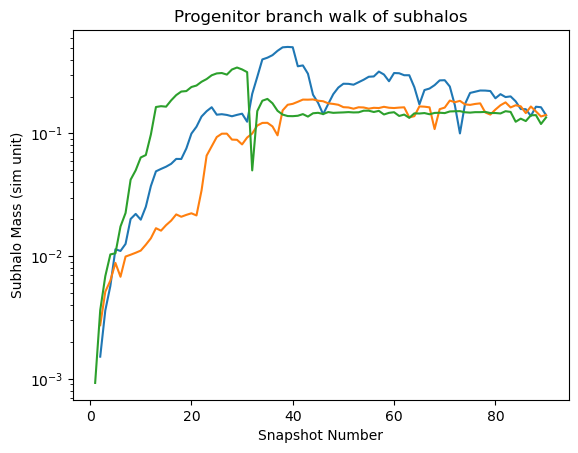

In [119]:
fields = ['SubhaloMass','SubfindID','SnapNum']

start = 100
for i in range(start,start+3):
    tree = il.sublink.loadTree(basePath,90,GroupFirstSub[i],fields=fields,onlyMPB=True)
    plt.plot(tree['SnapNum'],tree['SubhaloMass'],'-')
plt.yscale('log')
plt.xlabel('Snapshot Number')
plt.ylabel('Subhalo Mass (sim unit)')
plt.title('Progenitor branch walk of subhalos')

Text(0.5, 1.0, 'Descendent branch walk of subhalos')

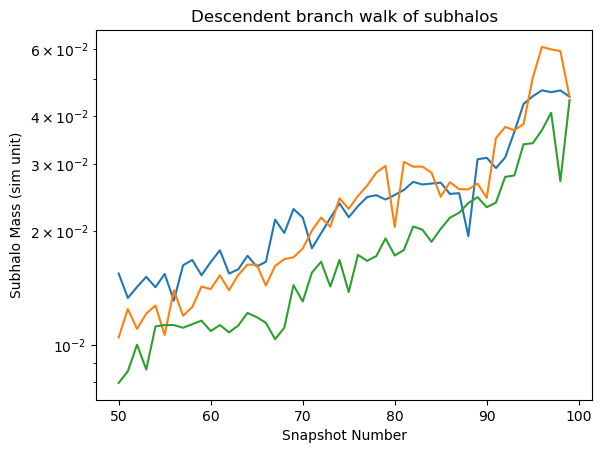

In [123]:
fields = ['SubhaloMass','SubfindID','SnapNum']

start = 100
for i in range(start,start+3):
    tree = il.sublink.loadTree(basePath,50,GroupFirstSub[i],fields=fields,onlyMDB=True)
    plt.plot(np.flip(tree['SnapNum']),tree['SubhaloMass'],'-')
plt.yscale('log')
plt.xlabel('Snapshot Number')
plt.ylabel('Subhalo Mass (sim unit)')
plt.title('Descendent branch walk of subhalos')

In [132]:
initial_snap = 60  # Starting snapshot
header = il.groupcat.loadHeader(basePath, initial_snap)

In [135]:
initial_z = header['Redshift']
print(initial_z)

0.6761104112134777


In [136]:
delta_z = 1.0 
target_z = initial_z - delta_z 

In [7]:
fields = ['SubhaloID', 'NextProgenitorID', 'MainLeafProgenitorID', 'FirstProgenitorID',
              'LastProgenitorID', 'RootDescendantID', 'SubhaloLenType', 'SubhaloMassType',
              'SnapNum', 'DescendantID', 'SubfindID']

In [10]:
il.sublink.loadTree(basePath,99,1, fields=fields, onlyMPB=False)

{'count': np.int64(262777),
 'SubhaloID': array([100568330, 100568331, 100568332, ..., 100831104, 100831105,
        100831106]),
 'NextProgenitorID': array([       -1, 100831101,        -1, ...,        -1,        -1,
               -1]),
 'MainLeafProgenitorID': array([100568428, 100568428, 100568428, ..., 100831106, 100831106,
        100831106]),
 'FirstProgenitorID': array([100568331, 100568332, 100568333, ..., 100831105, 100831106,
               -1]),
 'LastProgenitorID': array([100831106, 100831100, 100831100, ..., 100831106, 100831106,
        100831106]),
 'RootDescendantID': array([100568330, 100568330, 100568330, ..., 100568330, 100568330,
        100568330]),
 'SubhaloLenType': array([[    694, 4641598,       0,       0, 6880180,       1],
        [   1166, 4964931,       0,       0, 6908804,       1],
        [   1283, 5280474,       0,       0, 6935477,       1],
        ...,
        [      0,      29,       0,       0,       0,       0],
        [      0,      26,       